# Import

In [1]:
%matplotlib inline

import sys
import os
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import time
from scipy.special import softmax
from _context import *
from src.rl import ActorCriticWaterMaze
from src.environments import WaterMaze
from src.plotting import *
from src.memristor import *
import numpy as np
import matplotlib.pyplot as plt


def render(env, ax,draw_rbf=False,position=[0,0],cmap=plt.cm.get_cmap("Blues")):
        
        # ax = plt.gca()
        ax.axis('off')

        # Plot objective
        ax.add_patch(plt.Circle((0, 0), 0.5, color="red"))
        # Plot U shape
        ax.add_patch(plt.Rectangle((-2.5, -2.5), 1, 4.5, color="gray"))
        ax.add_patch(plt.Rectangle((1.5, -2.5), 1, 4.5, color="gray"))
        ax.add_patch(plt.Rectangle((-1.5, -2.5), 3, 1, color="gray"))

        norm_gauss = 1/(env.st_dev*np.sqrt(2*np.pi))
        halfway_x = env.st_dev*np.sqrt(2*np.log(2))

        rbf_1std = env.st_dev
        # Plot points
        for x in env.x_pos[:env.n_points]:
            for y in env.x_pos[:env.n_points]:
        # for x in env.x_pos:
        #     for y in env.y_pos:
                ax.plot(x, y,'.', c='black', markersize=2)
                if draw_rbf:
                    # draw circle of radius r
                    ax.add_patch(plt.Circle((x, y), halfway_x,
                                            edgecolor=(0.85, 0.85, 1, 0.01), fill=False, linewidth=0.5))


        # Plot outside boundaries
        ax.plot([-6, -6, 6, 6, -6], [-6, 6, 6, -6, -6], 'gray', alpha=0.5)
        cNorm  = colors.Normalize(vmin=0, vmax=1)
        scalarMap = ScalarMappable(norm=cNorm,cmap=cmap)
        color1 = scalarMap.to_rgba(1)
        color=color1#'#a4cefa'

        # Plot current position
        ax.plot(*position, '.',c=color, markersize=7)

        #Plot Possible Actions
        w_head=0.25
        l_head=0.25
        ax.arrow(*position, 0 , 1 , head_width=w_head, head_length=l_head,color=color,zorder=10)
        ax.arrow(*position, 0 , -1 , head_width=w_head, head_length=l_head,color=color,zorder=10)
        ax.arrow(*position, 1 , 0 , head_width=w_head, head_length=l_head,color=color,zorder=10)
        ax.arrow(*position, -1 , 0 , head_width=w_head, head_length=l_head,color=color,zorder=10)
        ax.arrow(*position, -1/np.sqrt(2) , -1/np.sqrt(2) , head_width=w_head, head_length=l_head,color=color,zorder=10)
        ax.arrow(*position, 1/np.sqrt(2) , 1/np.sqrt(2) , head_width=w_head, head_length=l_head,color=color,zorder=10)
        ax.arrow(*position, -1/np.sqrt(2) , 1/np.sqrt(2) , head_width=w_head, head_length=l_head,color=color,zorder=10)
        ax.arrow(*position, 1/np.sqrt(2) , -1/np.sqrt(2) , head_width=w_head, head_length=l_head,color=color,zorder=10)

        # plt.show()

# Colormap

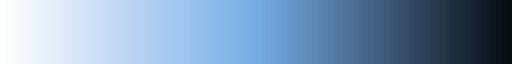

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colormap
n_bins = 100  # Number of bins
blues_new = [(1,1,1),(118/255, 173/255, 230/255),(0.02788235, 0.04764706, 0.06635294)]  
cmap_name = "blues_custom"
blues_custom_white_to_dark = LinearSegmentedColormap.from_list(cmap_name, blues_new, N=n_bins)


display(blues_custom_white_to_dark)


# Final Figure

### Load

In [3]:
#Note: extract files in results folder first!

# path='../results/results-extract_first/'
path='../results/'

# Standard Emulation
name1='Watermaze_optimum_memristor_emulation' 

# Low Noise Emulation
name2='Watermaze_optimum_min_noise_emulation' 

result1=pd.read_pickle(path+name1)
result_low_noise1=pd.read_pickle(path+name2)

keys = ['LR', 'T','step_size','std_dev_rbf','gamma','num_episodes','mean_final_rewards','mean_final_steps']
display(result1[keys])
display(result_low_noise1[keys])




,LR,T,step_size,std_dev_rbf,gamma,num_episodes,mean_final_rewards,mean_final_steps
0,0.04,0.15,1.5,0.75,0.975,[20000],1.0,15.79


,LR,T,step_size,std_dev_rbf,gamma,num_episodes,mean_final_rewards,mean_final_steps
0,0.07,0.15,1.5,0.75,0.975,[20000],1.0,15.13


## Plot

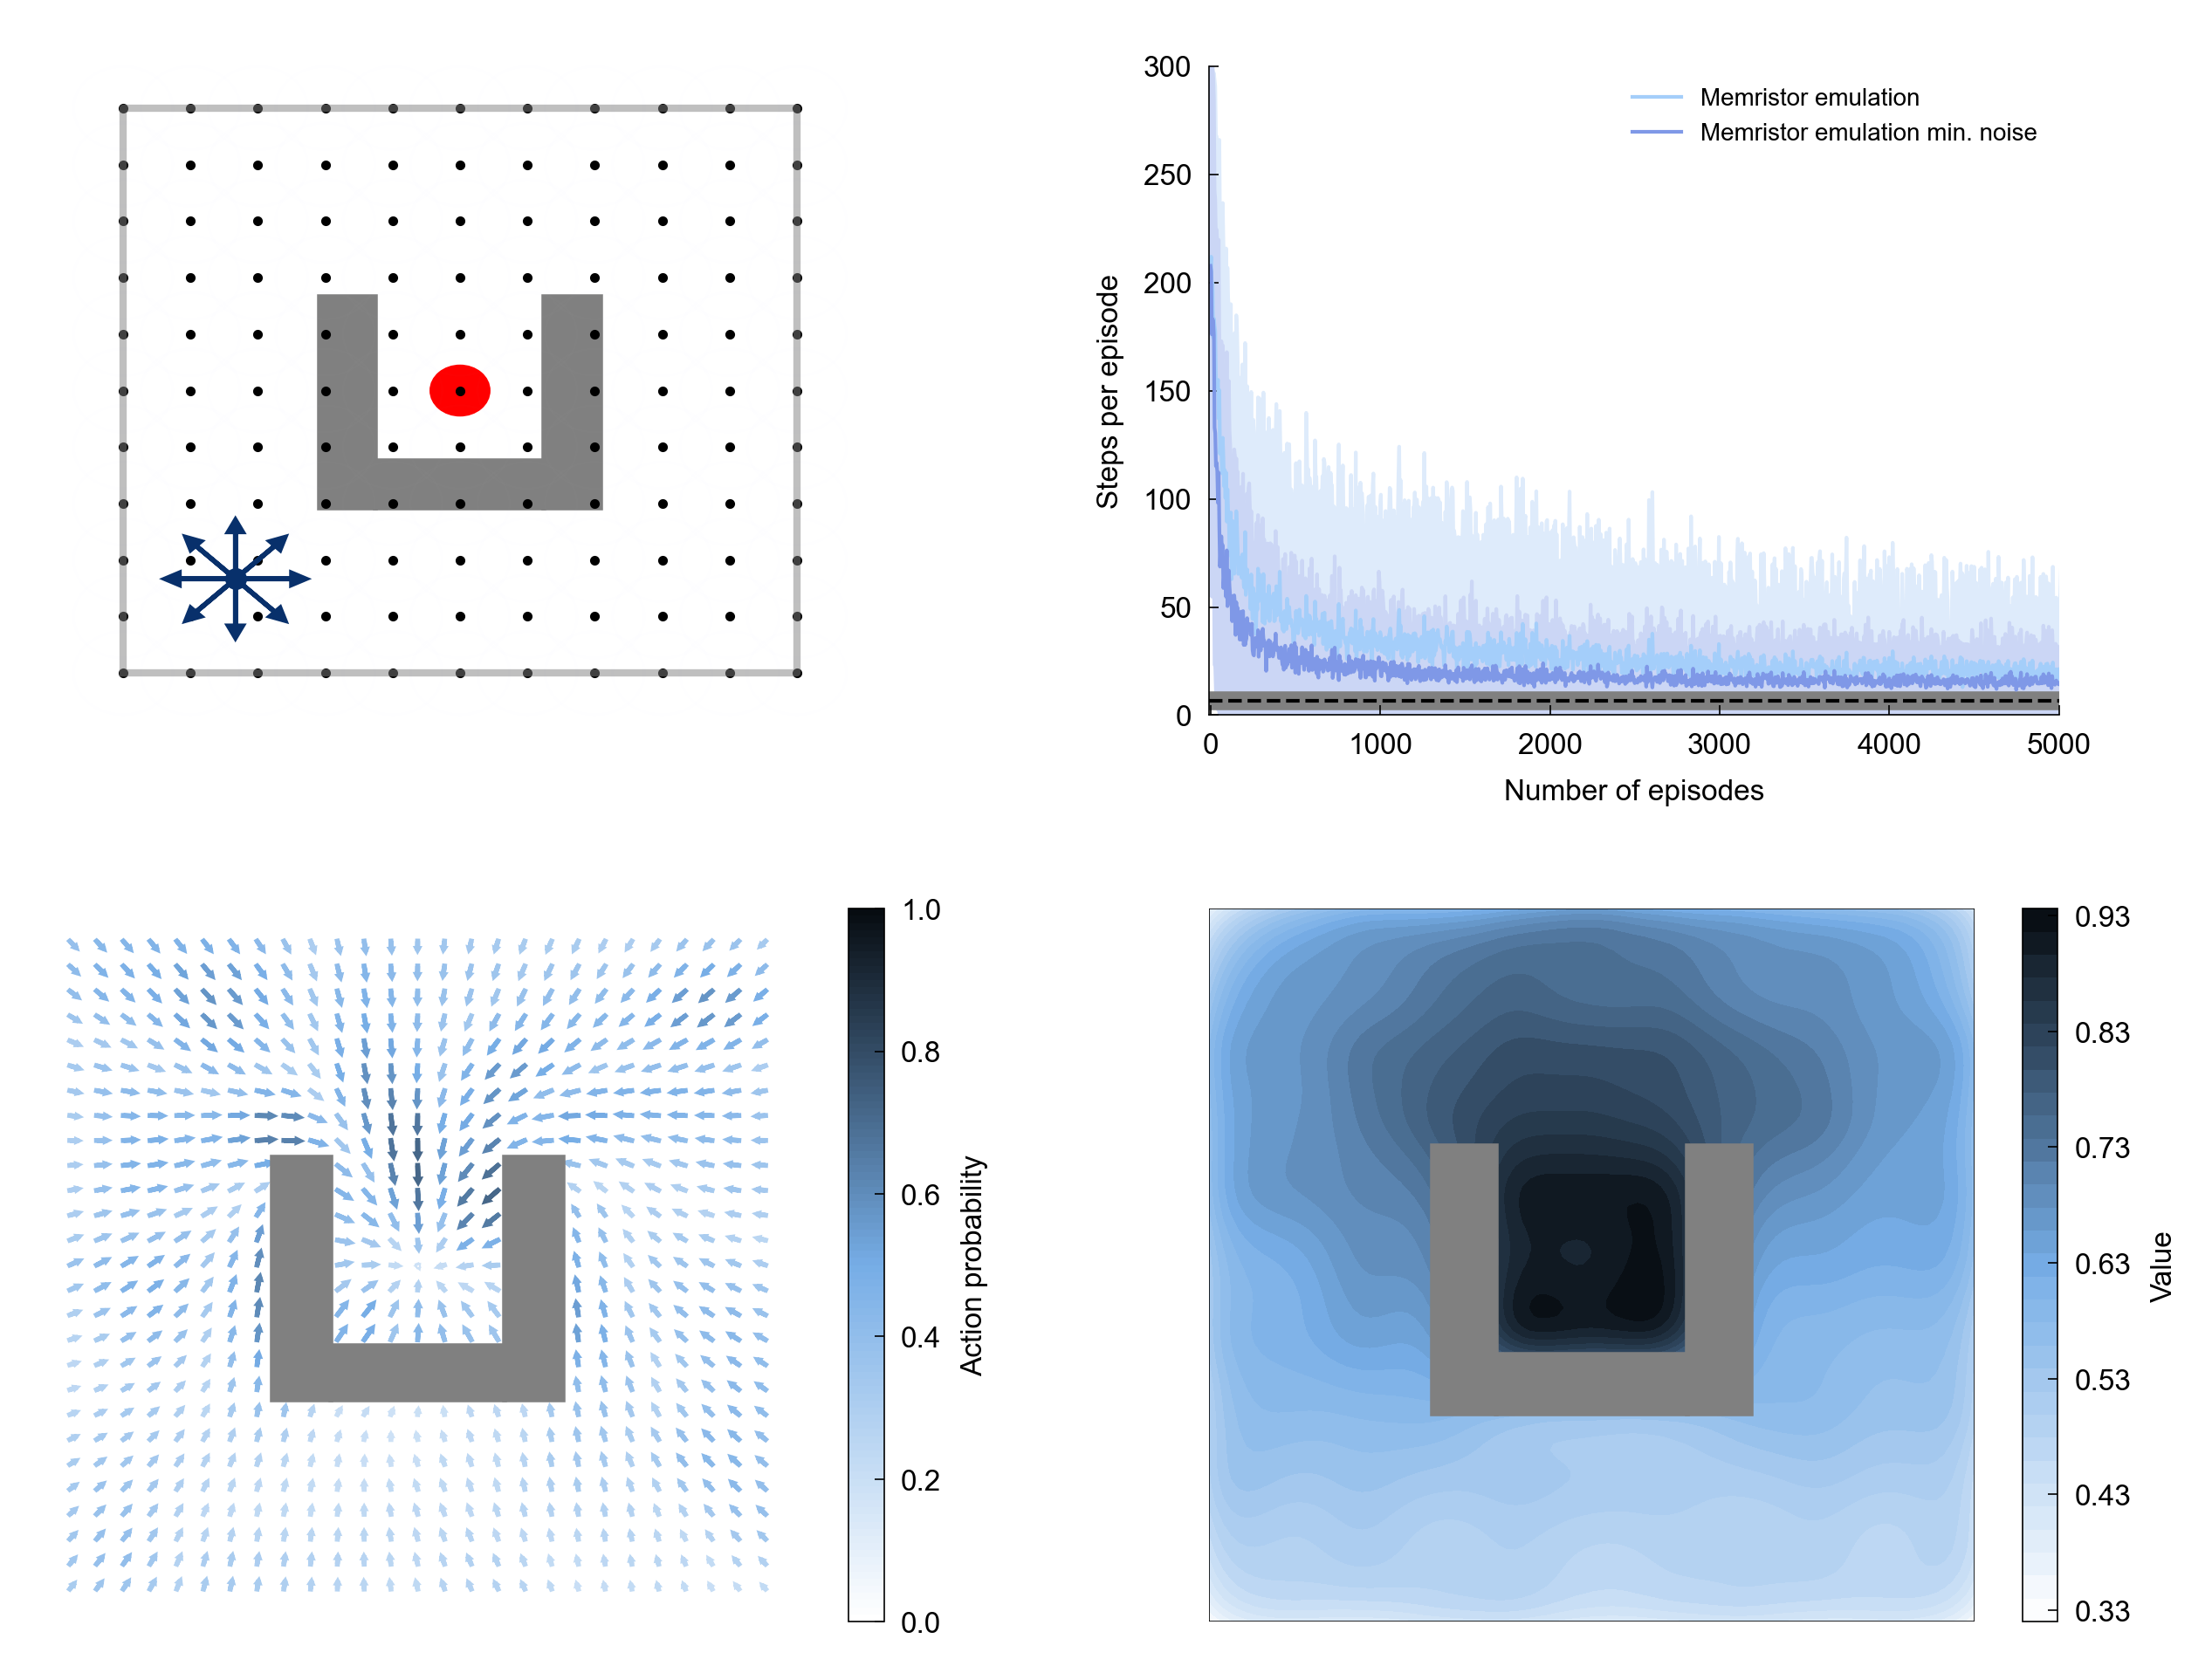

In [4]:
# Plot
font_size=6
#Plot Size----------
axis_thickness=0.3
params = {'figure.figsize': (20/2.54,15/2.54), #21cm is width of A4
          'legend.fontsize': str(font_size-1), #otherwise huge legend
          'axes.labelsize': str(font_size),
          'axes.titlesize': str(font_size),
          'xtick.labelsize':str(font_size), #was font_size-1
          'ytick.labelsize':str(font_size), #was font_size-1}
          
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 2,
          'ytick.major.size': 2,
          'xtick.major.width':axis_thickness,
          'ytick.major.width':axis_thickness,
          'axes.linewidth':str(axis_thickness),
          'axes.spines.top': False,
          'axes.spines.right': False,
          #Font
          'svg.fonttype': 'none', #editable fonts in svg
          'font.family': 'Arial',
          }
pylab.rcParams.update(params)

# Plotting of Steps
max_episode=5000
start=0
step=int(max_episode/1000)-1 #choose what episode to plot everything - note idx 0 -> episode 1000

#Policy Map and Value Map settings
n_points_actor=27
n_lvs_critic=35
position=[-4,-4]

#Colormap
cmap_actor=blues_custom_white_to_dark #before - blues_custom_darkest
cmap_value=blues_custom_white_to_dark #before - blues_custom_darker

linewidth=0.75
n_std=1

r=result1.iloc[0]
r_ln=result_low_noise1.iloc[0]

#Init Watermaze
no_states=11*11
n_episodes=r['num_episodes'][0]
T=r['T']
std_dev_rbf=r['std_dev_rbf']
step_size=r['step_size']
net = ActorCriticWaterMaze(no_states, T)
env = WaterMaze(no_states, st_dev=std_dev_rbf, step_size=step_size, w_scale=1)

#Get Steps and Rewards
rewards=r['rewards_list']
lengths=r['steps_list']

rewards_ln=r_ln['rewards_list']
lengths_ln=r_ln['steps_list']

#-mean-
mean_rewards=np.mean(rewards,axis=0)
mean_lengths=np.mean(lengths,axis=0)
mean_rewards_ln=np.mean(rewards_ln,axis=0)
mean_lengths_ln=np.mean(lengths_ln,axis=0)

#-std. dev-
std_dev_rewards=np.std(rewards,axis=0)
std_dev_steps=np.std(lengths,axis=0)
std_dev_rewards_ln=np.std(rewards_ln,axis=0)
std_dev_steps_ln=np.std(lengths_ln,axis=0)

#------Weights---------------
# mean of n seeds
net.w_a=np.mean(np.array(r['snapshot_list_actor'])[:,step,:,:],axis=0)
net.w_v=np.mean(np.array(r['snapshot_list_critic'])[:,step,:],axis=0)

# -- Plot --
plot_points1 = np.arange(len(mean_lengths))
plot_points2 = np.arange(len(std_dev_steps))

fig = plt.figure(dpi=400)
gs = GridSpec(100,100) 
ax1 = plt.subplot(gs[:45, :40])
ax2 = plt.subplot(gs[2:43, 55:95])
ax3 = plt.subplot(gs[55:, :45])
ax4 = plt.subplot(gs[55:, 55:])

#Render Task
render(env,ax=ax1,position=position,draw_rbf=True)

#Plot Steps vs. Episodes
ax2.plot(plot_points1[start::step], mean_lengths[start::step],color='#a4cefa',linewidth=linewidth) #7f98e7ff
ax2.plot(plot_points1[start::step], mean_lengths_ln[start::step],color='#7f98e7ff',linewidth=linewidth) #
ax2.fill_between(plot_points2[start::step],np.clip(mean_lengths-n_std*std_dev_steps,0,300)[start::step], np.clip(mean_lengths+n_std*std_dev_steps,0,300)[start::step],linewidth=linewidth,color='#deebfbff') # cbd6f5ff
ax2.fill_between(plot_points2[start::step],np.clip(mean_lengths_ln-n_std*std_dev_steps_ln,0,300)[start::step], np.clip(mean_lengths_ln+n_std*std_dev_steps_ln,0,300)[start::step],linewidth=linewidth,color='#cbd6f5ff') # 

#SW Reference at 5k episodes
mean_sw=6.65
std_sw= 3.163463292026635 
ax2.axhline(y=mean_sw, color='black', linestyle='--',linewidth=linewidth)

x=np.array([-10,n_episodes])
y=np.array([mean_sw,mean_sw])

ax2.fill_between(x,np.clip(y-n_std*std_sw,0,300), np.clip(y+n_std*std_sw,0,300),color='gray') # cbd6f5ff

ax2.set_xlim([-10,max_episode])
ax2.set_ylim([0,300])
ax2.set_xlabel("Number of episodes")
ax2.set_ylabel("Steps per episode")
ax2.legend(['Memristor emulation', 'Memristor emulation min. noise'], frameon=False)

#Render Actions
env.render_actions(net, ax3, dense=True, magnitude=True,n_points=n_points_actor,colormap=cmap_actor)
#Render Values
ticks=None
env.render_values(net, ax4, show_rbf=True,ticks=ticks,lvls=n_lvs_critic,colormap=cmap_value)

plt.show()

In [ ]:
#Save Figure
path='/../plots/'
name='Figure_5_plot'
os.makedirs(path,exist_ok=True)
fig.savefig(path+name+'.svg',format='svg',bbox_inches='tight',) #Save SVG
fig.savefig(path+name+'.png',dpi=600,format='png',bbox_inches='tight') #Save jpg